# Pytorch MNIST手書き数字の分類 - 畳み込み層ネットワーク -

- 畳み込み層（CNN）で構築したネットワークの実装を行い、MNIST分類を学習し推論します。

# 事前準備

## モジュールインポート

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

## GPUとCPUの自動判別

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用デバイス:", device)

使用デバイス: cpu


# Datasetの準備

## MNISTデータセット

In [3]:
#データ前処理 transform を設定
transform = transforms.Compose(
    [transforms.ToTensor(),                      # Tensor変換とshape変換 [H, W, C] -> [C, H, W]
     transforms.Normalize((0.5, ), (0.5, ))])    # 標準化 平均:0.5  標準偏差:0.5


#訓練用(train + validation)のデータセット サイズ:(channel, height, width) = (1,28,28) 60000枚
trainval_dataset = datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)

#訓練用ータセットを train と val にshuffleして分割する
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [40000, 20000])

print("train_dataset size = {}".format(len(train_dataset)))
print("val_dataset size = {}".format(len(val_dataset)))

#テスト(test)用のデータセット サイズ:(channel, height, width) = (1,28,28) 10000枚
test_dataset = datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)

train_dataset size = 40000
val_dataset size = 20000


# Detaloaderの作成

In [4]:
#訓練用 Dataloder
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=64,
                                            shuffle=True)
#検証用 Dataloder
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=64,
                                            shuffle=False)

#テスト用 Dataloder
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                            batch_size=64,
                                            shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

## 動作の確認

imges size =  torch.Size([64, 1, 28, 28])
labels size =  torch.Size([64])


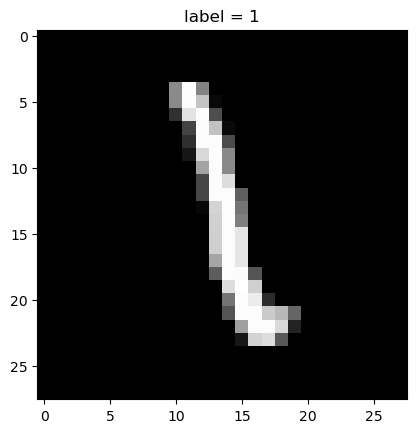

In [5]:
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
imges, labels = next(batch_iterator)  # 1番目の要素を取り出す
print("imges size = ", imges.size())
print("labels size = ", labels.size())

#試しに1枚 plot してみる
plt.imshow(imges[0].numpy().reshape(28,28), cmap='gray')
plt.title("label = {}".format(labels[0].numpy()))
plt.show()

# ネットワークモデルの作成
- 畳み込み層CNNのモデル

In [6]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)              # (Batch,  1, 28, 28) -> (Batch, 32, 26, 26)
        x = F.relu(x)
        x = self.conv2(x)              # (Batch, 32, 26, 26) -> (Batch, 64, 24, 24)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)         # (Batch, 64, 24, 24) -> (Batch, 64, 12, 12)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)        # (Batch, 64, 12, 12) -> (Batch, 9216)
        x = self.fc1(x)                # (Batch, 9216) -> (Batch, 128)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)                # (Batch, 128) -> (Batch, 10)

        return x

In [7]:
#モデル作成
net = Net().to(device)   # GPUを使用する場合のために明示的に .to(device) を指定

In [8]:
#ネットワークのレイヤー確認
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# 損失関数の定義

In [9]:
# nn.CrossEntropyLoss() はソフトマックス関数＋クロスエントロピー誤差
criterion = nn.CrossEntropyLoss()

# 最適化手法の設定

In [10]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 学習・検証の実施

In [11]:
# モデルを学習させる関数を作成
def train_model(net, dataloaders_dict, criterion, optimizer, device, num_epochs):
    
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for i , (inputs, labels) in tqdm(enumerate(dataloaders_dict[phase])):
                
                # GPUを使用する場合は明示的に指定
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):  # 訓練モードのみ勾配を算出
                    outputs = net(inputs)              # 順伝播
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)   # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))



In [12]:
# 学習・検証を実行する
# save load 参考：https://dreamer-uma.com/pytorch-model-save/
lswitch = False    # False: 学習済みモデルデータロード　True：学習してモデルデータ保存
PATH = "./my_mnist_model.pt"
if lswitch == False :
    num_epochs = 3
    train_model(net, dataloaders_dict, criterion, optimizer, device, num_epochs=num_epochs)
    # model = Net().to(device)
    torch.save(net.state_dict(), PATH)
    print(net)
    print(net.state_dict())
else:
    net = Net().to(device)
    net.load_state_dict(torch.load(PATH))
    print(net)
    #print(net.state_dict())


Epoch 1/3
-------------


0it [00:00, ?it/s]C:\Users\nakaj\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
313it [00:10, 30.51it/s]


val Loss: 2.3035 Acc: 0.1107
Epoch 2/3
-------------


625it [00:42, 14.62it/s]


train Loss: 0.2810 Acc: 0.9143


313it [00:10, 30.25it/s]


val Loss: 0.0705 Acc: 0.9786
Epoch 3/3
-------------


625it [00:45, 13.84it/s]


train Loss: 0.1100 Acc: 0.9677


313it [00:10, 31.18it/s]

val Loss: 0.0479 Acc: 0.9845
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
OrderedDict([('conv1.weight', tensor([[[[-7.4930e-02, -1.0620e-01,  1.8132e-01],
          [ 3.6460e-01,  6.6166e-02,  5.4672e-02],
          [-2.7535e-01,  1.9096e-02, -2.4549e-01]]],


        [[[ 1.0414e-01,  1.1349e-01,  4.3892e-01],
          [-1.3964e-01, -5.0086e-02,  1.3361e-01],
          [-4.6878e-01,  5.8313e-03,  9.9049e-02]]],


        [[[ 9.3759e-02,  2.8713e-01,  1.7080e-01],
          [-3.7234e-01, -2.9985e-01, -2.8572e-01],
          [ 8.1043e-02, -4.9943e-02,  6.3695e-02]]],


        [[[ 5.7373e-02, -9.2871e-02, -3.9082e-01],
          [ 4.0093e-01, -1.2712e-01, -3.5623e-01],
          [ 2.6596e-01,

# テストデータに対する予測

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([64])
tensor(7)
torch.Size([1, 1, 28, 28])


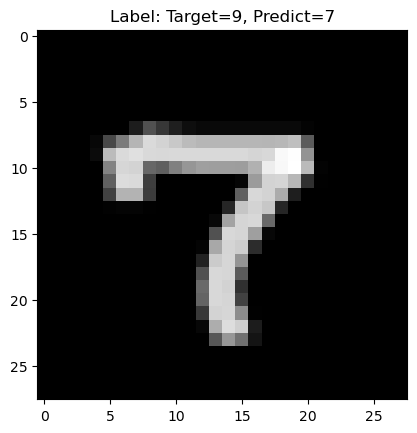

In [15]:
from PIL import Image, ImageOps
import torchvision

batch_iterator = iter(dataloaders_dict["test"])  # イテレータに変換
imges, labels = next(batch_iterator)  # 1番目の要素を取り出す
print (imges.size())
# print (imges[0])
print (imges.size()) # MNISTデータのフォーマット
print (imges[0].shape)
print (labels.shape)
print (labels[0])
mylabel = []
mylabel.append(9)

# https://qiita.com/oyngtmhr/items/ad5e1932ab4807dc0963
# img = Image.open('hands_mnist_1.png') # 'L':GrayScale　'1'：モノクロ
# img = Image.open('hands_mnist_2.png') # 'L':GrayScale　'1'：モノクロ
img = Image.open('hands_mnist_7.png') # 'L':GrayScale　'1'：モノクロ
img = ImageOps.invert(img.convert('L')).resize((28,28))
# img = img.resize((28,28))
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])
# 元のモデルに合わせて次元を追加
img = transform(img).unsqueeze(0)

print (img.shape)
plt.imshow(img.numpy().reshape(28,28), cmap='gray')

# test_data[np.newaxis].shape 
#plt.imshow(img)

net.eval() #推論モード
with torch.set_grad_enabled(False):   # 推論モードでは勾配を算出しない
    # outputs = net(imges)               # 順伝播
    outputs = net(img)               # 順伝播
    _, preds = torch.max(outputs, 1)  # ラベルを予測
    
#テストデータの予測結果を描画
# plt.imshow(imges[0].numpy().reshape(28,28), cmap='gray')
plt.imshow(img.numpy().reshape(28,28), cmap='gray')
plt.title("Label: Target={}, Predict={}".format(mylabel[0], preds[0].numpy()))
plt.show()

以上